# VIMS sky mosaic

This notebook projects Cassini VIMS (Visible Infrared Mapping Spectrometer) cubes on the sky from Enceladus-targeted flybys.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.colors import Normalize
from matplotlib.collections import PathCollection
import sys
import spiceypy as spice
from pyvims import VIMS
import os

# get the absolute path to the repository root
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# construct root path to data cubes
root_path = os.path.join(repo_root, "data", "cubes")

# E17 sequence (2012)
Retrieve cubes from the [VIMS Data Portal](https://vims.univ-nantes.fr) (Le Mouélic et al. (2019))

In [2]:
CUBE_IDS = [
    '1711536135_1', '1711536423_1', '1711536777_1', '1711537065_1', '1711537413_1',
    '1711537701_1', '1711538046_1', '1711538334_1', '1711538684_1', '1711538972_1',
    '1711539317_1', '1711539605_1', '1711539953_1', '1711540241_1', '1711540588_1',
    '1711540876_1', '1711541224_1', '1711541512_1', '1711541857_1', '1711542145_1',
    '1711542490_1', '1711542778_1', '1711543130_1', '1711543418_1', '1711543762_1',
    '1711544050_1', '1711544399_1', '1711544687_1', '1711545033_1', '1711545321_1',
    '1711545666_1', '1711545954_1', '1711546301_1', '1711546589_1', '1711546939_1',
    '1711547227_1', '1711547571_1', '1711547859_1', '1711548206_1', '1711548494_1',
    '1711548846_1', '1711549134_1', '1711549477_1', '1711549765_1', '1711550111_1',
    '1711550399_1', '1711550750_1', '1711551038_1', '1711551375_1', '1711551663_1',
    '1711552021_1', '1711552309_1', '1711552654_1', '1711552942_1', '1711553290_1',
    '1711553578_1',
    # "1711553950_1",
    # "1711554022_1"
]

CUBES = [VIMS(cube_id, root=root_path) for cube_id in CUBE_IDS]

In [3]:
data = np.array([
    cube.data
    for cube in CUBES
])

# retrieve camera corner pixel pointing direction in RA/DEC frame
paths = [
    Path(cube.rsky[:, l, s, :].T)
    for cube in CUBES
    for l in range(cube.NL)
    for s in range(cube.NS)
]

vertices = np.stack([
    path.vertices
    for path in paths
])

ra_min, dec_min = vertices.min(axis=(0, 1))
ra_max, dec_max = vertices.max(axis=(0, 1))

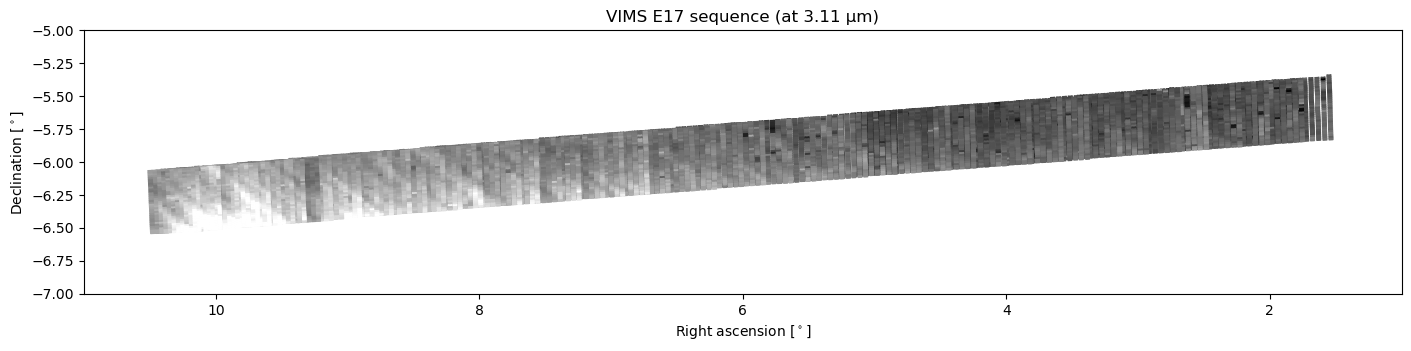

In [4]:
# i = 0    # 0.89 μm
i = 134  # 3.11 μm
# i = 254  # 5.11 μm

# normalise cmap over every cube in flyby
norm = Normalize(vmin=0, vmax=np.percentile(data[:, i, :, :], 99), clip=True)
colors = plt.get_cmap('gray')(norm(data[:, i, :, :].flatten()))

_, ax = plt.subplots(figsize=(17, 5))
ax.add_collection(PathCollection(paths, facecolors=colors, edgecolors=colors))

ax.set_aspect('equal')
ax.set_xlim(np.ceil(ra_max + .25), np.floor(ra_min - .25))
ax.set_ylim(np.floor(dec_min - .25), np.ceil(dec_max + .25))
ax.set_xlabel(r'Right ascension [$^\circ$]')
ax.set_ylabel(r'Declination [$^\circ$]')
ax.set_title(f'VIMS E17 sequence (at {CUBES[0].wvlns[i]:.2f} μm)');

wavelength 0.89191
wavelength 1.48239
wavelength 2.24065
wavelength 3.10562
wavelength 4.25697
wavelength 5.1145


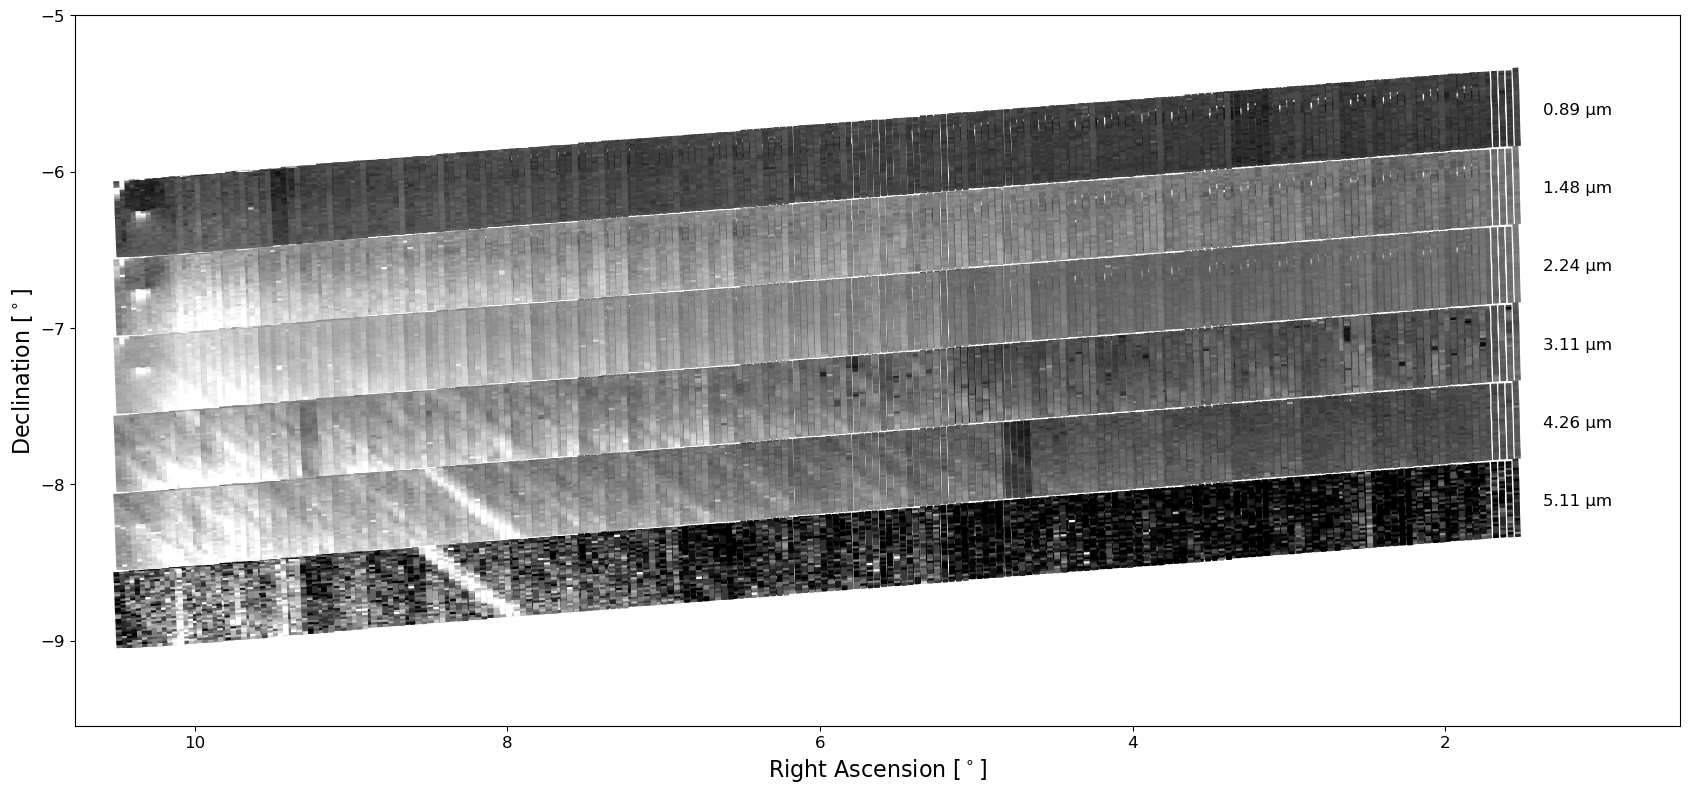

In [5]:
import matplotlib.transforms as transforms

# select which wavelengths to display
indices = [0, 36, 82, 134, 203, 254]
wavelengths = [CUBES[0].wvlns[i] for i in indices]
y_offset = 0  # initial y-offset

fig, ax = plt.subplots(figsize=(17, 8))

# loop through each index to plot the corresponding image
for i, wavelength in zip(indices, wavelengths):
    print("wavelength", wavelength)

    norm = Normalize(vmin=0, vmax=np.percentile(data[:, i, :, :], 99), clip=True)
    colors = plt.get_cmap('gray')(norm(data[:, i, :, :].flatten()))

    # offset the y-values for the current image
    offset_transform = transforms.Affine2D().translate(0, y_offset)
    offset_paths = [path.transformed(offset_transform) for path in paths]

    # plot the image with y-offset
    ax.add_collection(PathCollection(offset_paths, facecolors=colors, edgecolors=colors))

    # annotate text
    cord_n = int(CUBES[0].NS*CUBES[0].NL/2)+17
    if len(paths) > cord_n:
        x, y = paths[cord_n].vertices[0]
        x -= 0.65  # Apply the x-offset
        ax.text(x, y + y_offset, f'{wavelength:.2f} μm', fontsize=12, ha='center', va='center', color='black')

    # update the y-offset for the next image
    y_offset -= 0.5

ax.set_xlabel(r'Right Ascension [$^\circ$]', fontsize=16)
ax.set_ylabel(r'Declination [$^\circ$]', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.set_xlim(ra_max + .25, np.floor(ra_min - .25)-0.5)
ax.set_ylim(dec_min + y_offset, np.ceil(dec_max + .25))
ax.set_aspect('equal')

# Show the plot
plt.tight_layout()
plt.show()


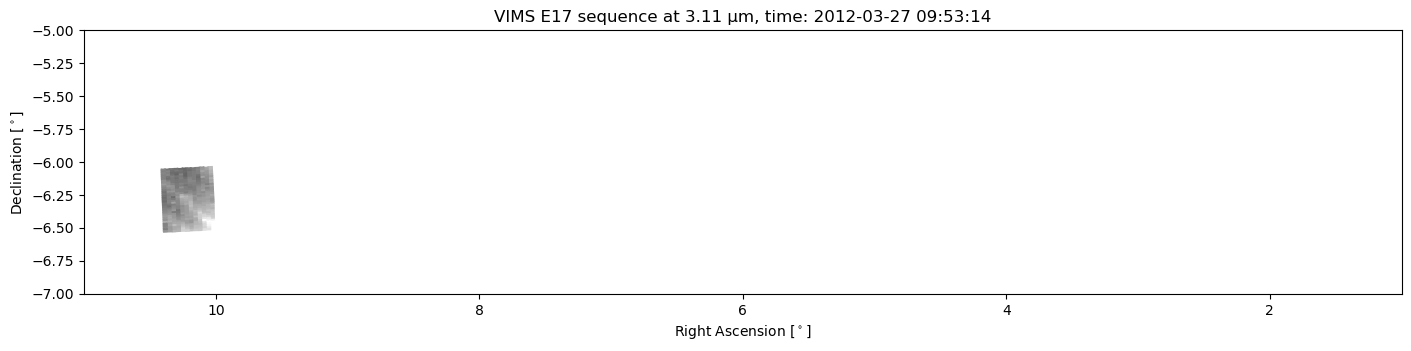

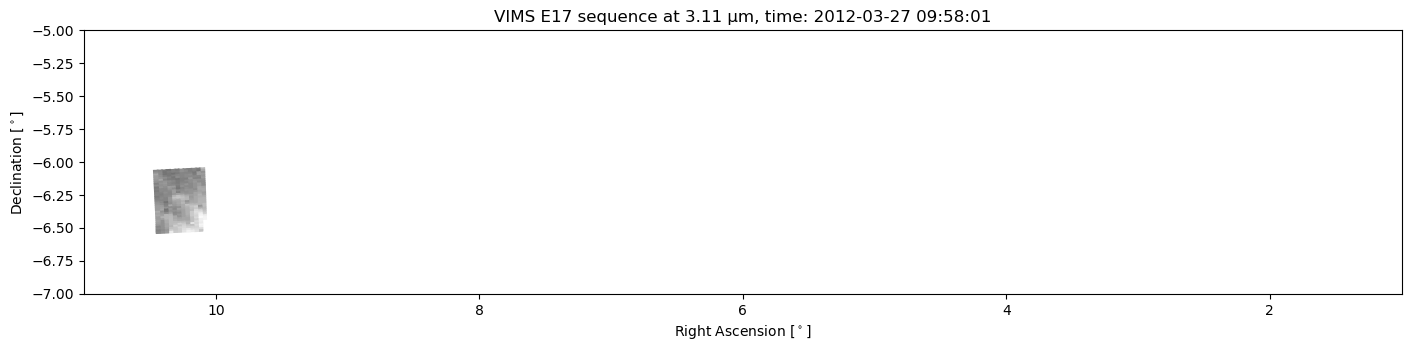

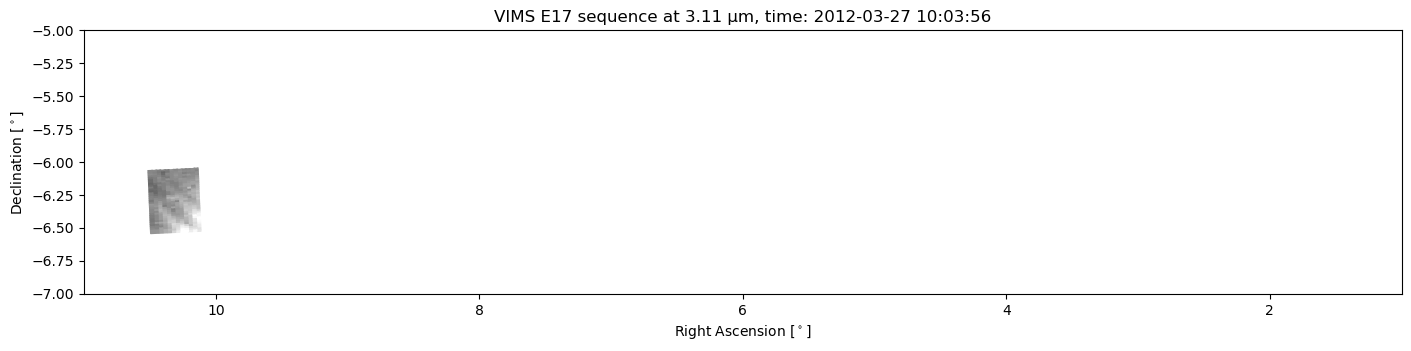

In [7]:

from datetime import datetime
ra_min, dec_min = vertices.min(axis=(0, 1))
ra_max, dec_max = vertices.max(axis=(0, 1))

# function to plot a single data cube on the sky
def plot_data_cube(cube, index, wavelength_index):
    paths = [Path(cube.rsky[:, l, s, :].T) for l in range(cube.NL) for s in range(cube.NS)]

    norm = Normalize(vmin=0, vmax=np.percentile(cube.data[wavelength_index, :, :], 99), clip=True)
    colors = plt.get_cmap('gray')(norm(cube.data[wavelength_index, :, :].flatten()))

    cube_time  = CUBES[index].time
    timestamp = datetime.fromisoformat(str(cube_time))
    f_timestamp = timestamp.strftime("%Y-%m-%d %H:%M:%S")

    fig, ax = plt.subplots(figsize=(17, 5))
    ax.add_collection(PathCollection(paths, facecolors=colors, edgecolors=colors))

    ax.set_aspect('equal')
    ax.set_xlim(np.ceil(ra_max + .25), np.floor(ra_min - .25))
    ax.set_ylim(np.floor(dec_min - .25), np.ceil(dec_max + .25))
    ax.set_xlabel(r'Right Ascension [$^\circ$]')
    ax.set_ylabel(r'Declination [$^\circ$]')
    ax.set_title(f'VIMS E17 sequence at {cube.wvlns[wavelength_index]:.2f} μm, time: {f_timestamp}')
    plt.show()
    plt.close()

# wavelength_index = 0    # 0.89 μm
wavelength_index = 134  #  3.11 μm
# wavelength_index  = 254  # 5.11 μm
# iterate over each cube and plot it separately (choose the last 3 here because there are a lot)
for index, cube in enumerate(CUBES[-3:]):
    plot_data_cube(cube, index, wavelength_index)

# Flyby E19 (2012)

In [10]:
E19_CUBE_IDS = [
    # '1714609767_1', '1714609943_1', '1714610119_1', '1714610267_1',
    # '1714610443_1', '1714610619_1', '1714610795_1', '1714610971_1',
    # '1714611147_1', '1714611323_1', '1714629434_1',
    '1714629711_1', '1714630011_1', '1714630311_1', '1714630699_1',
    '1714630999_1', '1714631299_1', '1714631677_3', '1714631977_1',
    '1714632277_1', '1714632697_1'
]

CUBES = [VIMS(cube_id, root=root_path, download=True) for cube_id in E19_CUBE_IDS]

In [11]:

data = np.array([
    cube.data
    for cube in CUBES
])

paths = [
    Path(cube.rsky[:, l, s, :].T)
    for cube in CUBES
    for l in range(cube.NL)
    for s in range(cube.NS)
]


vertices = np.stack([
    path.vertices
    for path in paths
])

ra_min, dec_min = vertices.min(axis=(0, 1))
ra_max, dec_max = vertices.max(axis=(0, 1))

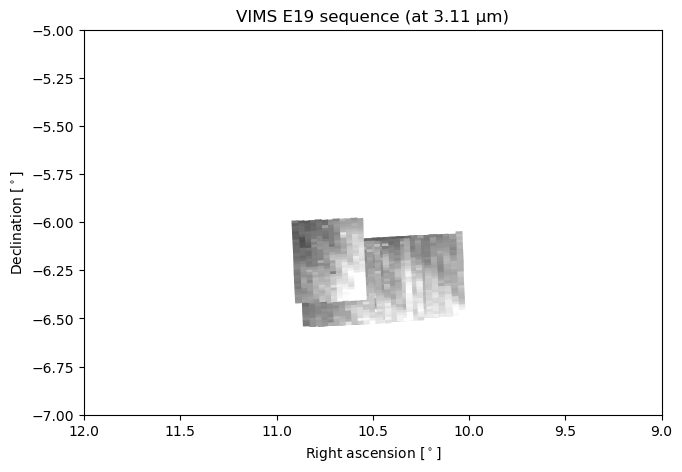

In [12]:
# i = 0    # 0.89 μm
i = 134  # 3.11 μm
# i = 254  # 5.11 μm

# normalise cmap over every cube in flyby
norm = Normalize(vmin=0, vmax=np.percentile(data[:, i, :, :], 99), clip=True)
colors = plt.get_cmap('gray')(norm(data[:, i, :, :].flatten()))

_, ax = plt.subplots(figsize=(17, 5))
ax.add_collection(PathCollection(paths, facecolors=colors, edgecolors=colors))

ax.set_aspect('equal')
ax.set_xlim(np.ceil(ra_max + .25), np.floor(ra_min - .25))
ax.set_ylim(np.floor(dec_min - .25), np.ceil(dec_max + .25))
ax.set_xlabel(r'Right ascension [$^\circ$]')
ax.set_ylabel(r'Declination [$^\circ$]')
ax.set_title(f'VIMS E19 sequence (at {CUBES[0].wvlns[i]:.2f} μm)');

# Flyby E13 (2010)

In [13]:
E13_CUBE_IDS = [
    "1671579308_1", "1671580116_1", "1671580920_1",
    "1671581723_1", "1671582524_1", "1671583330_1"
]

CUBES = [VIMS(cube_id, root=root_path, download=True) for cube_id in E13_CUBE_IDS]

In [14]:
data = np.array([
    cube.data
    for cube in CUBES
])

paths = [
    Path(cube.rsky[:, l, s, :].T)
    for cube in CUBES
    for l in range(cube.NL)
    for s in range(cube.NS)
]

vertices = np.stack([
    path.vertices
    for path in paths
])

ra_min, dec_min = vertices.min(axis=(0, 1))
ra_max, dec_max = vertices.max(axis=(0, 1))

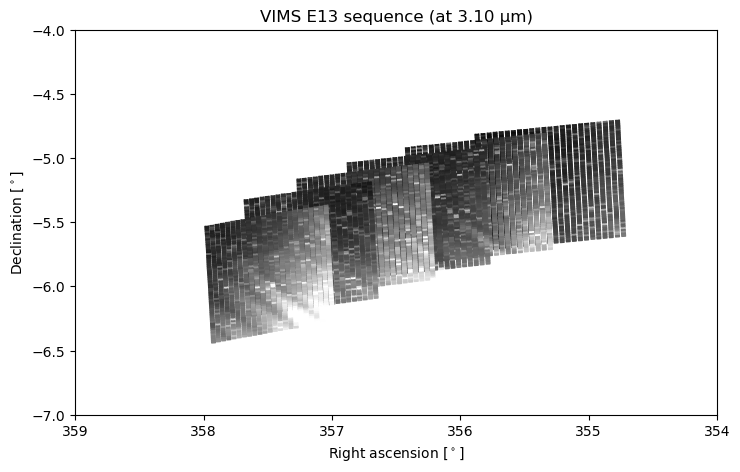

In [15]:
# i = 0    # 0.89 μm
i = 134  # 3.11 μm
# i = 254  # 5.11 μm

# normalise cmap over every cube in flyby
norm = Normalize(vmin=0, vmax=np.percentile(data[:, i, :, :], 99), clip=True)
colors = plt.get_cmap('gray')(norm(data[:, i, :, :].flatten()))

_, ax = plt.subplots(figsize=(17, 5))
ax.add_collection(PathCollection(paths, facecolors=colors, edgecolors=colors))

ax.set_aspect('equal')
ax.set_xlim(np.ceil(ra_max + .25), np.floor(ra_min - .25))
ax.set_ylim(np.floor(dec_min - .25), np.ceil(dec_max + .25))
ax.set_xlabel(r'Right ascension [$^\circ$]')
ax.set_ylabel(r'Declination [$^\circ$]')
ax.set_title(f'VIMS E13 sequence (at {CUBES[0].wvlns[i]:.2f} μm)');